## visualDet3D

In [129]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm
import time

from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn

    # Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

CUDA available: True


OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 1.96 GiB total capacity; 1.06 GiB already allocated; 3.44 MiB free; 1.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [ ]:
def get_predictions(index):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())
        
        rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
        
        return rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo
    
#     if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
#         for box in bbox_3d_corner_homo:
#             box = box.cpu().numpy().T
#             rgb_image = draw_3D_box(rgb_image, box)
#     if is_draw:
#         plt.imshow(np.clip(rgb_image, 0, 255))
        
#     return np.clip(rgb_image, 0, 255)

## tracking + trajectory 

In [ ]:
import numpy as np
import collections

from filterpy.kalman import KalmanFilter

In [ ]:
def linear_assignment(cost_matrix):
    try:
        import lap
        _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
        return np.array([[y[i],i] for i in x if i >= 0]) #
    except ImportError:
        from scipy.optimize import linear_sum_assignment
        x, y = linear_sum_assignment(cost_matrix)
        return np.array(list(zip(x, y)))

def iou_batch(bb_test, bb_gt):
    """
    From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
    """
    bb_gt = np.expand_dims(bb_gt, 0)
    bb_test = np.expand_dims(bb_test, 1)

    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])                                      
    + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)                                              
    return(o)  


def convert_bbox_to_z(bbox):
    """
    Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio
    """
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w * h    #scale is just area
    r = w / float(h)
    return np.array([x, y, s, r]).reshape((4, 1))

def convert_x_to_bbox(x,score=None):
    """
    Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
    """
    w = np.sqrt(x[2] * x[3])
    h = x[2] / w
    if(score==None):
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
    else:
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))

def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.3):
    """
    Assigns detections to tracked object (both represented as bounding boxes)

    Returns 3 lists of matches, unmatched_detections and unmatched_trackers
    """
    if(len(trackers)==0):
        return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)

    iou_matrix = iou_batch(detections, trackers)

    if min(iou_matrix.shape) > 0:
        a = (iou_matrix > iou_threshold).astype(np.int32)
        if a.sum(1).max() == 1 and a.sum(0).max() == 1:
            matched_indices = np.stack(np.where(a), axis=1)
        else:
            matched_indices = linear_assignment(-iou_matrix)
    else:
        matched_indices = np.empty(shape=(0,2))

    unmatched_detections = []
    for d, det in enumerate(detections):
        if(d not in matched_indices[:,0]):
            unmatched_detections.append(d)
    unmatched_trackers = []
    for t, trk in enumerate(trackers):
        if(t not in matched_indices[:,1]):
            unmatched_trackers.append(t)

    #filter out matched with low IOU
    matches = []
    for m in matched_indices:
        if(iou_matrix[m[0], m[1]]<iou_threshold):
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)

    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

In [ ]:
class KalmanBoxTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as bbox.
    """
    count = 0
    def __init__(self,bbox,no_of_past_frames=5,no_of_future_frames=5):
        """
        Initialises a tracker using initial bounding box.
        """
        #define constant velocity model
        self.kf = KalmanFilter(dim_x=7, dim_z=4) 
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

        self.kf.R[2:,2:] *= 10.
        self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
        self.kf.P *= 10.
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01

        self.kf.x[:4] = convert_bbox_to_z(bbox)
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []

        self.no_of_past_frames = no_of_past_frames
        self.no_of_future_frames = no_of_future_frames
        self.update_history = collections.deque(maxlen=self.no_of_past_frames)
        self.predict_history = collections.deque(maxlen=self.no_of_future_frames)

        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def update(self,bbox):
        """
        Updates the state vector with observed bbox.
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(convert_bbox_to_z(bbox))
        self.update_history.append(bbox)

        if  len(self.update_history)>=self.no_of_past_frames :
            kbt = KalmanBoxTrajectory(self.update_history[0])
            for j in range(1,self.no_of_past_frames):
                kbt.predict()
                p = kbt.update(self.update_history[j])
            for k in range(self.no_of_future_frames):
                p = kbt.predict()[0]
                self.predict_history.append(p)


    def predict(self):
        """
        Advances the state vector and returns the predicted bounding box estimate.
        """
        if((self.kf.x[6]+self.kf.x[2])<=0):
          self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        if(self.time_since_update>0):
          self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return convert_x_to_bbox(self.kf.x)

    def get_future_predictions(self):
        """
        Returns the future bounding box estimate.
        """
        return np.array(self.predict_history)
    

In [ ]:
class KalmanBoxTrajectory(object):
  """
  This class represents the internal state of individual tracked objects observed as bbox.
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    """
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=7, dim_z=4) 
    self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.id = KalmanBoxTrajectory.count
    KalmanBoxTrajectory.count += 1
    self.history = []

  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.history = []
    self.kf.update(convert_bbox_to_z(bbox))    

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)

In [ ]:
#trajectory class
class Trajectory(object):
  def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3, no_of_future_frames=5, no_of_past_frames=5):
    """
    Sets key parameters for Trajectory
    """
    self.max_age = max_age
    self.min_hits = min_hits
    self.iou_threshold = iou_threshold
    self.trackers = []
    self.frame_count = 0

    self.no_of_future_frames = no_of_future_frames
    self.no_of_past_frames = no_of_past_frames


  def update(self, dets=np.empty((0, 5))):
    """
    Params:
      dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
    Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
    Returns the a similar array, where the last column is the object ID.

    NOTE: The number of objects returned may differ from the number of detections provided.
    """
    self.frame_count += 1
    # get predicted locations from existing trackers.
    trks = np.zeros((len(self.trackers), 5))
    to_del = []
    ret = []
    for t, trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if np.any(np.isnan(pos)):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks, self.iou_threshold)

    # update matched trackers with assigned detections
    for m in matched:
      self.trackers[m[1]].update(dets[m[0], :])

    # create and initialise new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoxTracker(dets[i,:],self.no_of_past_frames,self.no_of_future_frames)
        self.trackers.append(trk)
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0] #current bounding box position
        fp = trk.get_future_predictions() #future predictions
        if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
          ret.append([d,fp, trk.id]) 
        i -= 1
        # remove dead tracklet
        if(trk.time_since_update > self.max_age):
          self.trackers.pop(i)
    if(len(ret)>0):
      return np.array(ret)
    return np.empty((0,5))

## trajectory testing

In [ ]:
from IPython.display import clear_output

In [ ]:
#create instance of Trajectory
mot_tracker = Trajectory() 

In [ ]:
rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo=get_predictions(0)


In [ ]:
print(bbox_2d)
print(bbox_3d_corner_homo)

In [ ]:
rgb_image_c=rgb_image.copy()
coords_2d = bbox_2d[0].cpu()
coords_3d = bbox_3d_corner_homo[0].cpu()
print(coords_2d)
# x1,y1,x2,y2=int(coords_2d[0]),int(coords_2d[1]),int(coords_2d[2]),int(coords_2d[3])
x1,y1 = int(coords_3d[0][0]), int(coords_3d[0][1])
x2,y2 = int(coords_3d[2][0]), int(coords_3d[2][1])
color=(255, 0, 255)
cv2.rectangle(rgb_image_c, (x1,y1),(x2,y2), color, 3)
# if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
#         for box in bbox_3d_corner_homo:
#             box = box.cpu().numpy().T
#             rgb_image = draw_3D_box(rgb_image, box)
# box = coords_3d.cpu().numpy().T
# rgb_image = draw_3D_box(rgb_image, box)
fig = plt.figure(figsize=(16,9))
plt.imshow(np.clip(rgb_image_c, 0, 255))
plt.show()

In [ ]:
def assignTrackID(index):
    # get detections
    rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo=get_predictions(index)
    
    if len(scores) > 0:
        
        """
            NOTE: In 3D bbox_3d_corner_homo 0,1,2,7 are the coordinates of the front face of the 3D bounding box
        """
        
        
        detectionsList=[]
        for i in range(len(scores)):
            #for 2d bounding box
#             detection=np.append((bbox_2d[i]).cpu(),scores[i].cpu())
            
            #for 3D bounding box converting to 2D
            coords_3d = bbox_3d_corner_homo[i].cpu()
            x1,y1 = coords_3d[0][0], coords_3d[0][1]
            x2,y2 = coords_3d[2][0], coords_3d[2][1]
            bb=[x1,y1,x2,y2]
            detection=np.append(bb,scores[i].cpu())
            
            detectionsList.append(detection)
        detectionsNumPyArray = np.asarray(detectionsList)
#         print('-------detectionsNumPyArray-------\n',detectionsNumPyArray)
#         print('-------type detectionsNumPyArray-------\n',type(detectionsNumPyArray))
#         print('-------detectionsNumPyArray 0-------\n',detectionsNumPyArray[0])
        # update SORT
        #  def update(self, dets=np.empty((0, 5))):
        """
            Params:
              dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
            Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
            Returns the a similar array, where the last column is the object ID.

            NOTE: The number of objects returned may differ from the number of detections provided.
        """
        track_bbs_ids_list = mot_tracker.update(detectionsNumPyArray)
#         print('-------track_bbs_ids_list-------\n',track_bbs_ids_list)
    # track_bbs_ids is a np array where each row contains a valid bounding box and track_id (last column)

        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)

        track_bbs_ids_list=track_bbs_ids_list.tolist()
        
        for track_bbs_ids in track_bbs_ids_list:
            coords = track_bbs_ids[0]
            x1,y1,x2,y2=int(coords[0]),int(coords[1]),int(coords[2]),int(coords[3])
            trackID=int(track_bbs_ids[-1])
            name="ID: {}".format(str(trackID))

            # font
            font = cv2.FONT_HERSHEY_SIMPLEX
            # org
            org = (x1, y1-10)
            # fontScale
            fontScale = 0.9
            # Line thickness of 2 px
            thickness = 2
            # Blue color in BGR
            color=(0, 255, 255)
            text_color_bg=(0, 0, 0)
            text_size, _ = cv2.getTextSize(name, font, fontScale, thickness)
            text_w, text_h = text_size
            cv2.rectangle(rgb_image, (x1 , y1-10 - text_h), (x1 + text_w, y1-10), text_color_bg, -1)
            
            # Using cv2.putText() method
            cv2.putText(rgb_image,name, org, font, fontScale, color, thickness, cv2.LINE_AA)

                
# def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
#     drawed_image = image.copy()
#     for box2d in bboxes2d:
#         cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
#     return drawed_image
            
    return np.clip(rgb_image, 0, 255), track_bbs_ids_list

In [ ]:
imagei,track_bbs_ids=assignTrackID(1)
# print(track_bbs_ids)
for bbs in track_bbs_ids: #for each vehicle in a image frame
    bb=bbs[0] #current bounding box
    future_bb=bbs[1] #future bounding boxes
    vehicle_id=bbs[-1] #vehicle id
    print('bb coords',bb)
    print('trackID',bbs[-1])
    print('future coords',future_bb,'\n')

0 



/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


track_bbs_ids []


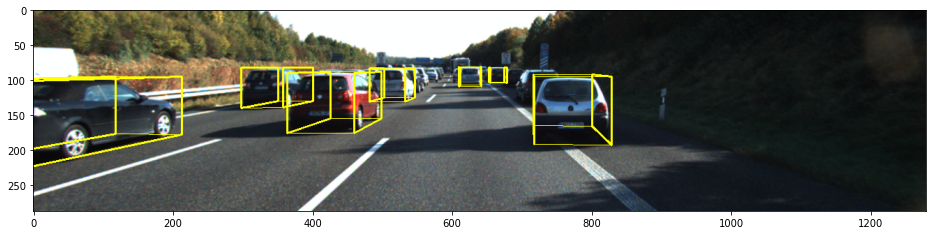

1 

track_bbs_ids []


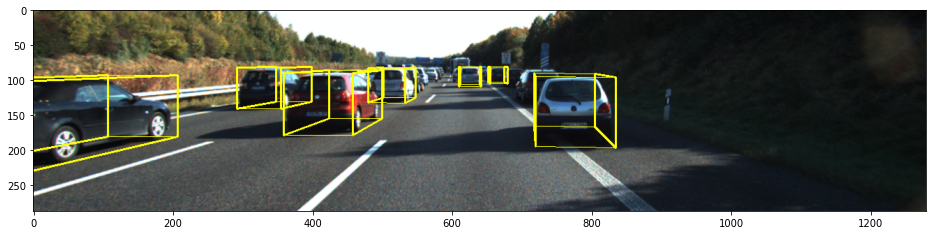

2 

track_bbs_ids []


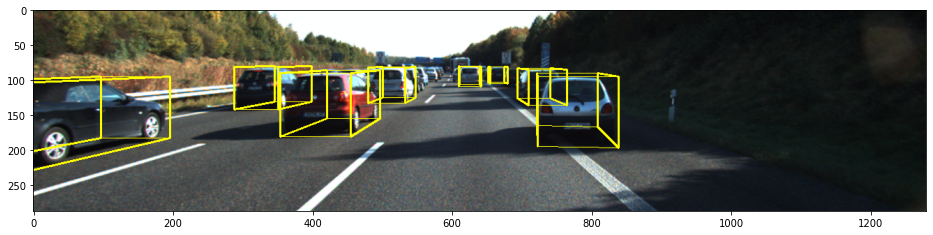

3 

track_bbs_ids []


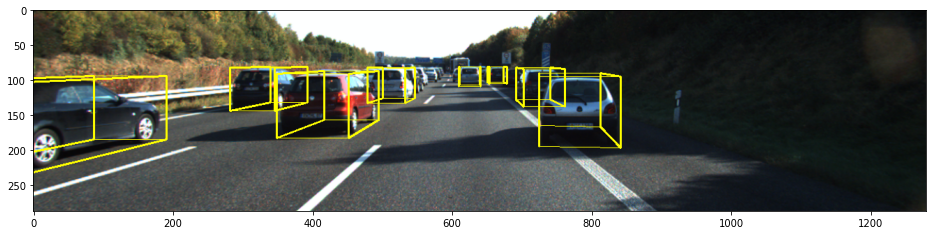

4 

track_bbs_ids []


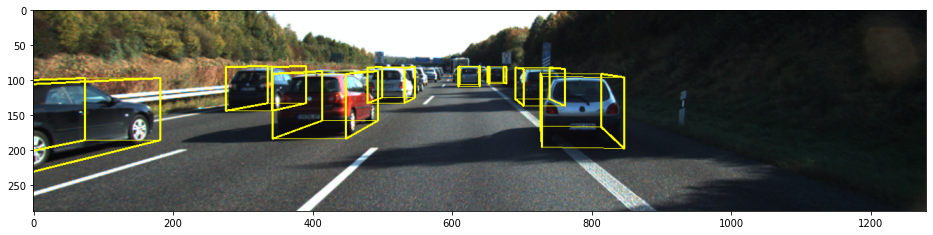

5 

track_bbs_ids []


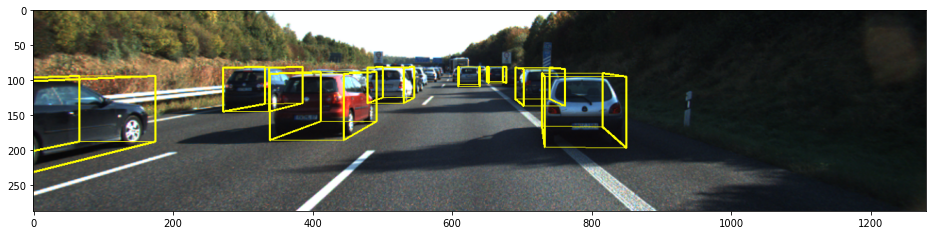

6 

track_bbs_ids []


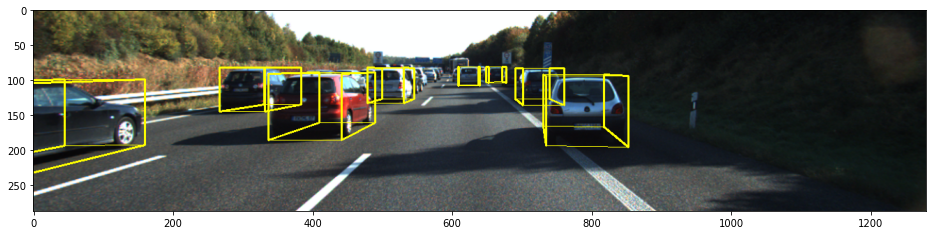

7 

track_bbs_ids []


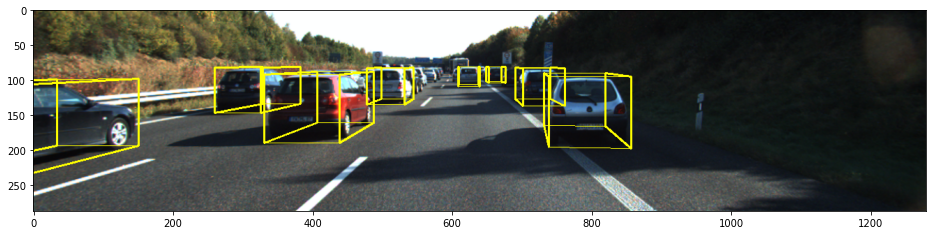

8 

track_bbs_ids [[array([610.85900645,  81.22632186, 638.81307443, 106.72644485]), array([], dtype=float64), 677]]
bb coords [610.85900645  81.22632186 638.81307443 106.72644485]
trackID 677
future coords [] 



/home/theekshana/anaconda3/envs/YOLO3D/lib/python3.7/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


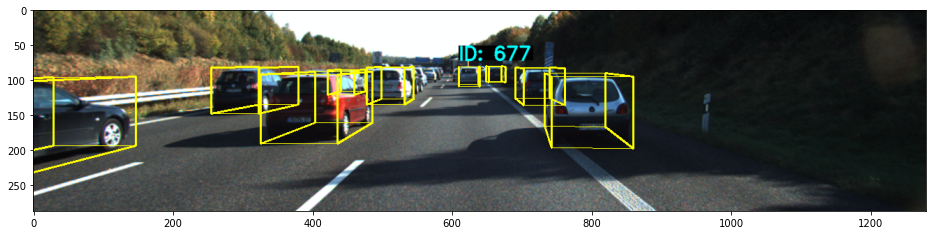

9 

track_bbs_ids [[array([611.25613148,  81.12262759, 639.40112022, 106.81524632]), array([], dtype=float64), 677]]
bb coords [611.25613148  81.12262759 639.40112022 106.81524632]
trackID 677
future coords [] 



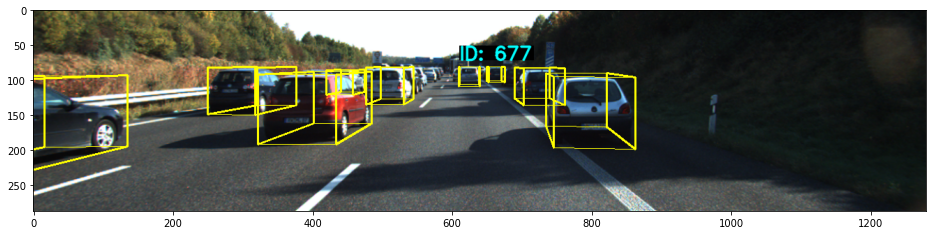

In [128]:
current_bb_list=[]
future_bb_list=[]
vehicle_id_list=[]
image_list=[]
track_list_all_objects=[]
size = 10

for frame in range (size): #for each image frame
    print(frame,'\n')
    current_bb_frame=[]
    future_bb_frame=[]
    vehicle_id_frame=[]
    imagei,track_bbs_ids=assignTrackID(frame)
    print('track_bbs_ids',track_bbs_ids)
    
    for bbs in track_bbs_ids: #for each vehicle in a image frame
        bb=bbs[0] #current bounding box
        future_bb=bbs[1] #future bounding boxes
        vehicle_id=bbs[-1] #vehicle id
        print('bb coords',bb)
        print('trackID',bbs[-1])
        print('future coords',future_bb,'\n')
        current_bb_frame.append(bb)
        future_bb_frame.append(future_bb)
        vehicle_id_frame.append(vehicle_id)
        
    current_bb_list.append(current_bb_frame)
    future_bb_list.append(future_bb_frame)
    vehicle_id_list.append(vehicle_id_frame)
    image_list.append(imagei)
    track_list_all_objects.append(track_bbs_ids)
    
    fig = plt.figure(figsize=(16,9))
    plt.imshow(imagei)
    plt.show()
    

In [45]:
x0_danger_zone=400#300#400
x1_danger_zone=800#900#800
y0_danger_zone=300
y1_danger_zone=200#150#200
w_danger_zone=100#150#100

In [53]:
x0 = x0_danger_zone
x1 = x1_danger_zone
y0 = y0_danger_zone
y1 = y1_danger_zone
w = w_danger_zone

def is_in_zone(x,y):
    if x0<x<x1 and y0>y>y1:
        return True
    return False

def get_zone_check_point(bb):
    x0,y0,x1,y1=bb
    if x0<x1_danger_zone:
        x=x0
    else:
        x=x1
    y=max(y0,y1)
    return x,y

def show_zone_warning(image_c,id_list):
#     fig = plt.figure(figsize=(16,9))
#     clear_output(wait=True)
#     draw_danger_zone(image_c)

    message= "Warning! ID:"+ str(id_list)

    font = cv2.FONT_HERSHEY_SIMPLEX
    org = 480,60
    fontScale = 1
    thickness = 1
    color=(255,0,0)

    cv2.putText(image_c,message, org, font, fontScale, color, thickness, cv2.LINE_AA)
#     plt.imshow(image_c)
#     plt.show()

def show_future_warning(image_c,id_list):
#     fig = plt.figure(figsize=(16,9))
#     clear_output(wait=True)
#     draw_danger_zone(image_c)

    message= "Future Warning! ID:"+ str(id_list)

    font = cv2.FONT_HERSHEY_SIMPLEX
    org = 480,30
    fontScale = 1
    thickness = 1
    color=(255,0,0)

    cv2.putText(image_c,message, org, font, fontScale, color, thickness, cv2.LINE_AA)
    
def draw_danger_zone(rgb_image):
    thickness=3
    color=text_color_bg=(0, 125, 255)
    pts=np.array([[x0,y0],[x0+w,y1],[x1-w,y1],[x1,y0]],np.int32)
    isClosed=True
    cv2.polylines(rgb_image, [pts],isClosed, color, thickness)
#     cv2.rectangle(rgb_image, (x0 , y0), (x1, y1), text_color_bg, 0)    

In [ ]:
for frame,track in enumerate(track_list_all_objects):
    print('frame',frame)
    for vehicle in track:
        bb=vehicle[0] #current bounding box
        future_bbs=vehicle[1] #future bounding boxes
        vehicle_ID=int(vehicle[-1]) #vehicle id
        
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            print('Warning!','Frame:',frame,'vehicle ID:',i)
            
        for i,future_bb in enumerate (future_bbs):
            x,y=get_zone_check_point(future_bb)
            if is_in_zone(x,y):
                print('Warning!','Future Frame: ',i,'vehicle ID:',vehicle_ID)

frame 0


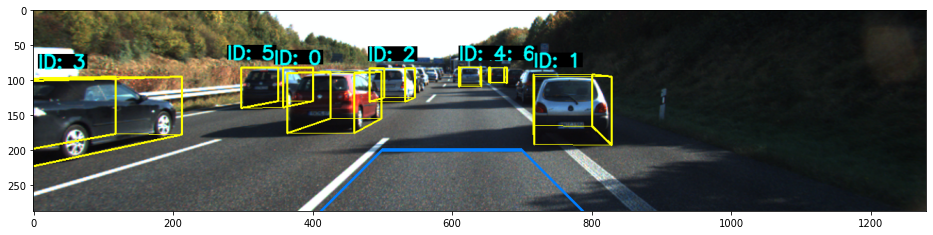

frame 1


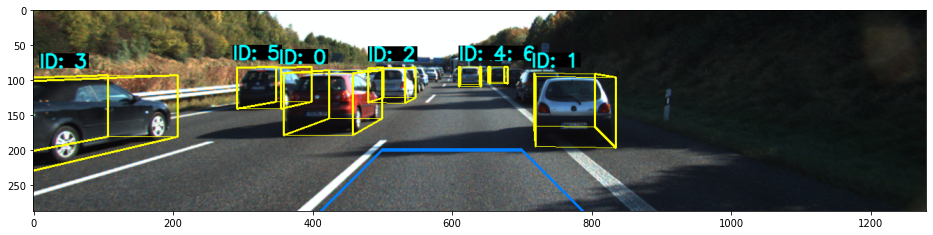

frame 2


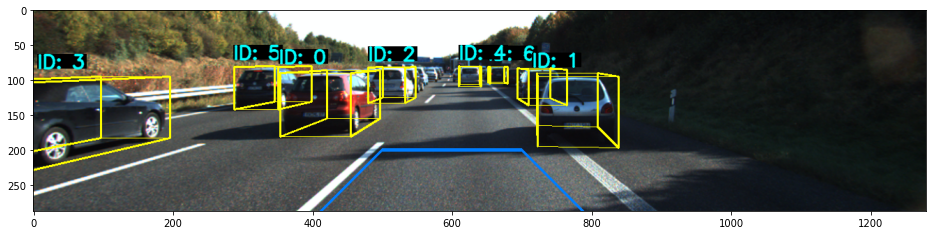

frame 3


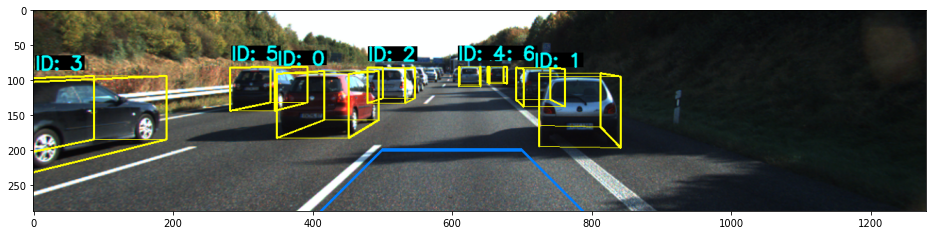

frame 4


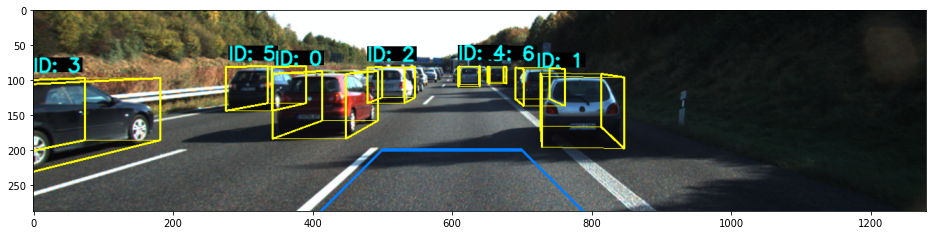

frame 5


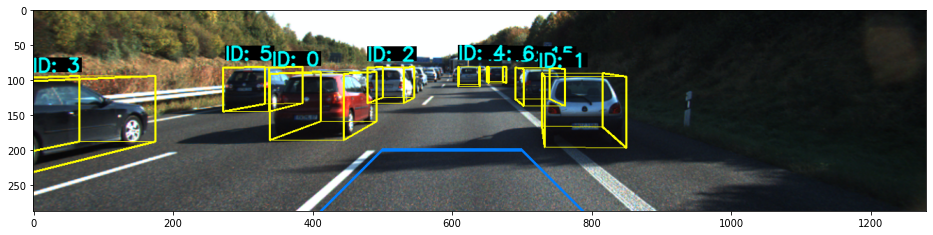

frame 6


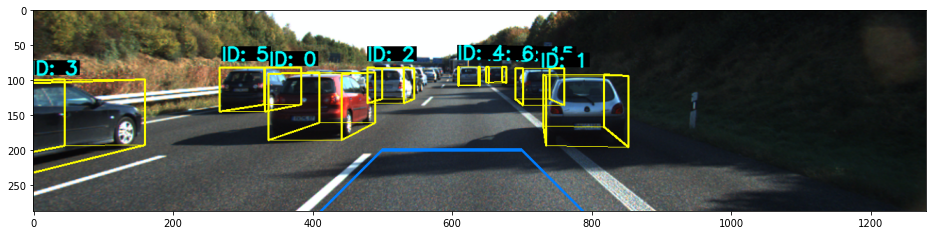

frame 7


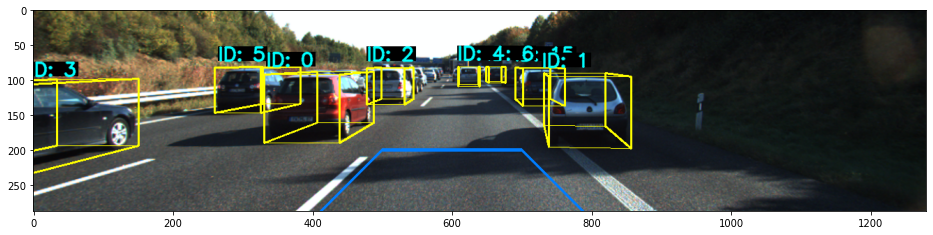

frame 8
Warning! Future Frame:  4 vehicle ID: 1


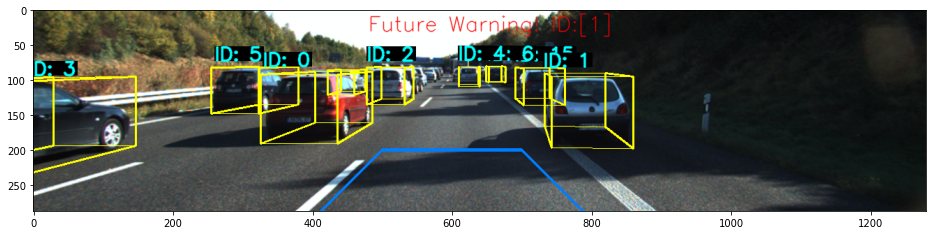

frame 9
Warning! Future Frame:  3 vehicle ID: 1
Warning! Future Frame:  4 vehicle ID: 1


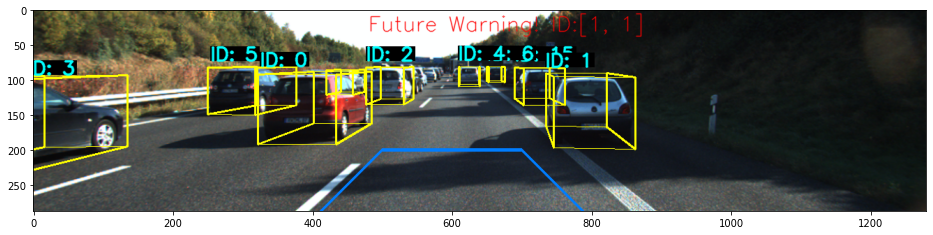

In [54]:
# plt.ion()
#to show inside notebook 
image_list_c = image_list.copy()
%matplotlib inline 
for frame,track_frame in enumerate(track_list_all_objects):
    id_list=[]
    future_id_list=[]
    print('frame',frame)
    for vehicle in track_frame:
        bb=vehicle[0] #current bounding box
        future_bbs=vehicle[1] #future bounding boxes
        vehicle_ID=int(vehicle[-1]) #vehicle id
        
        x,y=get_zone_check_point(bb)
        if is_in_zone(x,y):
            id_list.append(vehicle_ID)
            print('Warning!','Frame:',frame,'vehicle ID:',vehicle_ID)
            
        for i,future_bb in enumerate (future_bbs):
            x,y=get_zone_check_point(future_bb)
            if is_in_zone(x,y):
                future_id_list.append(vehicle_ID)
                print('Warning!','Future Frame: ',i,'vehicle ID:',vehicle_ID)

        image=image_list_c[frame].copy()
        draw_danger_zone(image)
    if len(id_list)>0:
        show_zone_warning(image,id_list)
    if len(future_id_list)>0:
        show_future_warning(image,future_id_list)
    #         clear_output(wait=True) #to show in same window 
    #       plt.close()
    fig = plt.figure(figsize=(16,9))
    plt.imshow(image)
    plt.show()
            
#     cv2.imwrite("data/collision_warning %03d.png"%frame,cv2.cvtColor(image, cv2.COLOR_RGB2BGR))